<a href="https://colab.research.google.com/github/nirvika3395/ArtificialIntelligence--Project-/blob/main/Fake_news_detection_using_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import all required libraries
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

# Scikit-learn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    accuracy_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    classification_report
)

# Load the dataset from HuggingFace

ds = load_dataset(
    "koliskos/fake_news",
    data_files={"fake": "Fake.csv", "true": "True.csv"}
)

print("Dataset loaded successfully!")
print(ds)
print(ds.keys())

Loading dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/78.0 [00:00<?, ?B/s]

Fake.csv:   0%|          | 0.00/62.8M [00:00<?, ?B/s]

True.csv:   0%|          | 0.00/53.6M [00:00<?, ?B/s]

Generating fake split: 0 examples [00:00, ? examples/s]

Generating true split: 0 examples [00:00, ? examples/s]

Dataset loaded successfully!
DatasetDict({
    fake: Dataset({
        features: ['title', 'text', 'subject', 'date'],
        num_rows: 23481
    })
    true: Dataset({
        features: ['title', 'text', 'subject', 'date'],
        num_rows: 21417
    })
})
dict_keys(['fake', 'true'])


In [ ]:
# Convert to pandas DataFrames
df_fake = ds["fake"].to_pandas()
df_true = ds["true"].to_pandas()

# Add labels: 0 for fake news, 1 for true news
df_fake["label"] = 0  # Fake news
df_true["label"] = 1  # True news

print("\nFake news distribution:")
print(df_fake["label"].value_counts())
print("\nTrue news distribution:")
print(df_true["label"].value_counts())

# Combine both datasets
df = pd.concat([df_fake, df_true], ignore_index=True)

print(f"\nFinal dataset shape: {df.shape}")
print("Label distribution in combined dataset:")
print(df["label"].value_counts())

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


Fake news distribution:
label
0    23481
Name: count, dtype: int64

True news distribution:
label
1    21417
Name: count, dtype: int64

Final dataset shape: (44898, 5)
Label distribution in combined dataset:
label
0    23481
1    21417
Name: count, dtype: int64


In [ ]:
def clean_text(text):
    """
    Clean and preprocess text data
    """
    # Handle None values
    if text is None:
        text = ""

    # Convert to string and lowercase
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)

    # Remove text between asterisks
    text = re.sub(r"\*.*?\*", "", text)

    # Keep only letters and spaces
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text

# Apply text cleaning

df["title"] = df["title"].fillna("")
df["text"] = df["text"].fillna("")

# Combine title and text
df["content"] = df["title"] + " " + df["text"]
df["content_clean"] = df["content"].apply(clean_text)


print(df[["content_clean", "label"]].head())

                                       content_clean  label
0  ben stein calls out th circuit court committed...      0
1  trump drops steve bannon from national securit...      1
2  puerto rico expects us to lift jones act shipp...      1
3  oops trump just accidentally confirmed he leak...      0
4  donald trump heads for scotland to reopen a go...      1


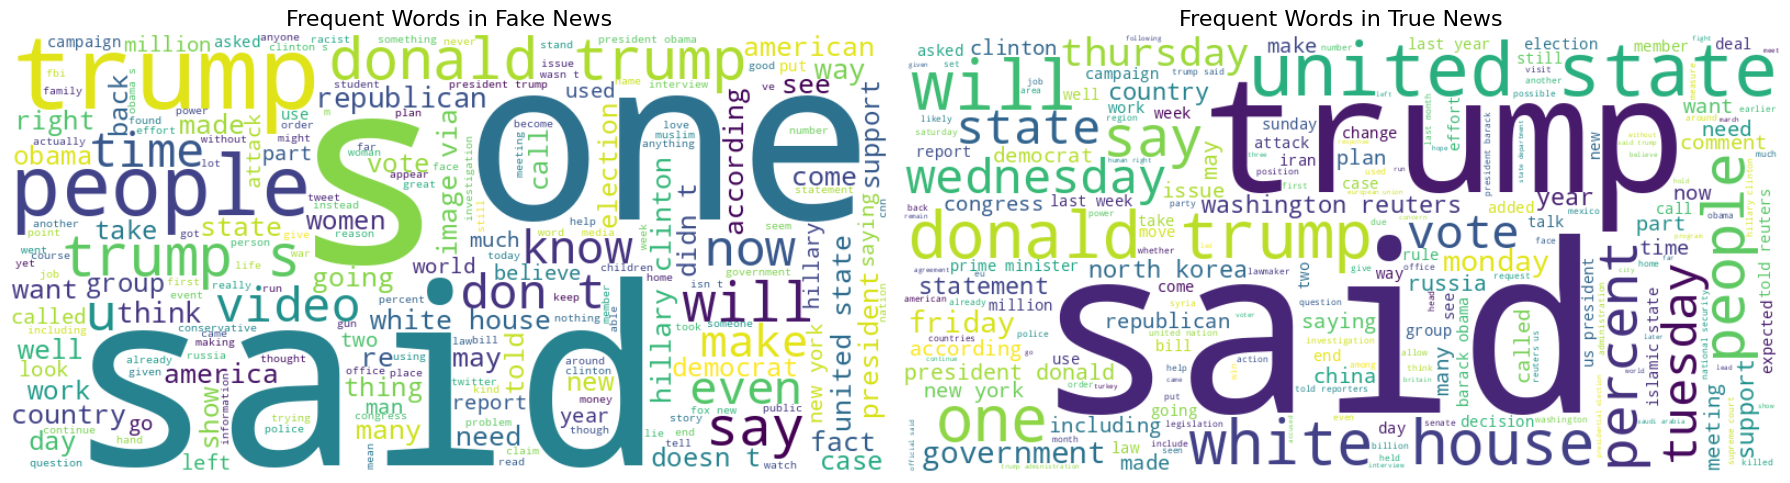

In [ ]:
# Generate Word Clouds for Fake vs Real News
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all cleaned text for each class
fake_text = " ".join(df[df['label']==0]['content_clean'])
true_text = " ".join(df[df['label']==1]['content_clean'])

# Generate word clouds
wordcloud_fake = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
wordcloud_true = WordCloud(width=800, height=400, background_color='white').generate(true_text)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes[0].imshow(wordcloud_fake, interpolation='bilinear')
axes[0].set_title('Frequent Words in Fake News', fontsize=16)
axes[0].axis('off')

axes[1].imshow(wordcloud_true, interpolation='bilinear')
axes[1].set_title('Frequent Words in True News', fontsize=16)
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    stop_words="english",
    min_df=2,
    max_df=0.95
)

# Transform text to TF-IDF features
print("\nCreating TF-IDF features...")
X = tfidf.fit_transform(df["content_clean"])
y = df["label"]

print(f"Feature matrix shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")


Creating TF-IDF features...
Feature matrix shape: (44898, 20000)
Number of features: 20000


In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nData split completed:")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Train label distribution:\n{y_train.value_counts()}")
print(f"Test label distribution:\n{y_test.value_counts()}")


Data split completed:
Training samples: 35918
Testing samples: 8980
Train label distribution:
label
0    18785
1    17133
Name: count, dtype: int64
Test label distribution:
label
0    4696
1    4284
Name: count, dtype: int64


In [ ]:
# Define models with hyperparameters
models = {
    "Naive Bayes (MNB)": MultinomialNB(alpha=0.5),
    "Logistic Regression": LogisticRegression(
        max_iter=4000,
        solver="liblinear",
        C=1.0,
        class_weight="balanced",
        random_state=42
    ),
    "Linear SVM (LinearSVC)": LinearSVC(
        C=1.0,
        class_weight="balanced",
        random_state=42
    )
}

# Train all models
print("\nTraining models...")
for name, clf in models.items():
    clf.fit(X_train, y_train)
    print(f"✓ Trained: {name}")
print("All models trained successfully!")


Training models...
✓ Trained: Naive Bayes (MNB)
✓ Trained: Logistic Regression
✓ Trained: Linear SVM (LinearSVC)
All models trained successfully!


In [ ]:
def get_scores(clf, X):
    """
    Get continuous scores for ROC/PR curves
    """
    if hasattr(clf, "predict_proba"):
        return clf.predict_proba(X)[:, 1]
    else:
        return clf.decision_function(X)

# Evaluate all models
results = []
print("\n" + "="*70)

for name, clf in models.items():
    y_pred = clf.predict(X_test)
    y_scores = get_scores(clf, X_test)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_scores)
    pr = average_precision_score(y_test, y_scores)

    # Store results
    results.append({
        "model": name,
        "accuracy": acc,
        "f1": f1,
        "roc_auc": roc,
        "pr_auc": pr
    })

    # Print results for this model
    print(f"\nMODEL: {name}")
    print("-" * 40)
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc:.4f}")
    print(f"PR-AUC: {pr:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    print("="*70)

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("\nSummary of all models:")
print(results_df.to_string(index=False))



MODEL: Naive Bayes (MNB)
----------------------------------------
Accuracy: 0.9589
F1 Score: 0.9571
ROC-AUC: 0.9914
PR-AUC: 0.9902

Classification Report:
              precision    recall  f1-score   support

           0     0.9636    0.9576    0.9606      4696
           1     0.9539    0.9603    0.9571      4284

    accuracy                         0.9589      8980
   macro avg     0.9587    0.9590    0.9588      8980
weighted avg     0.9589    0.9589    0.9589      8980


MODEL: Logistic Regression
----------------------------------------
Accuracy: 0.9906
F1 Score: 0.9902
ROC-AUC: 0.9995
PR-AUC: 0.9995

Classification Report:
              precision    recall  f1-score   support

           0     0.9944    0.9876    0.9910      4696
           1     0.9866    0.9939    0.9902      4284

    accuracy                         0.9906      8980
   macro avg     0.9905    0.9908    0.9906      8980
weighted avg     0.9907    0.9906    0.9906      8980


MODEL: Linear SVM (LinearSVC)



Generating confusion matrices...


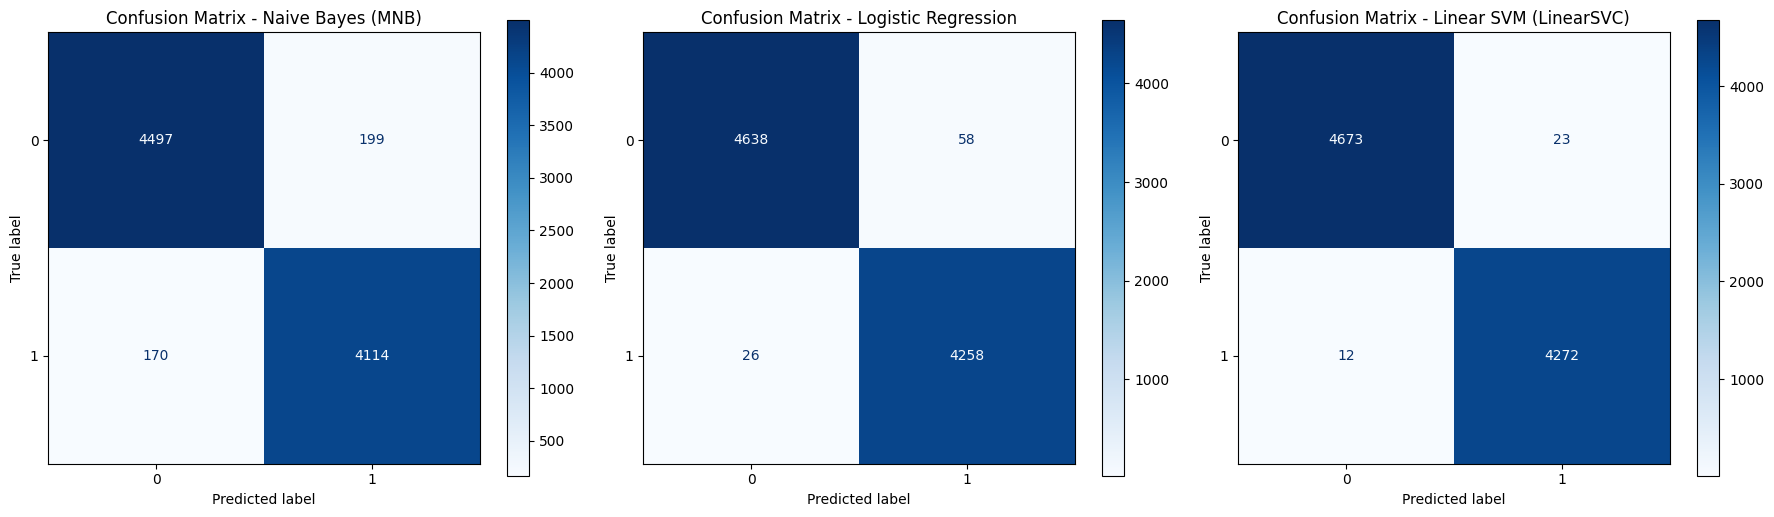

In [ ]:
# Plot confusion matrices for all models
print("\nGenerating confusion matrices...")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, clf) in enumerate(models.items()):
    y_pred = clf.predict(X_test)

    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        ax=axes[idx],
        values_format="d",
        cmap="Blues"
    )
    axes[idx].set_title(f"Confusion Matrix - {name}")
    axes[idx].grid(False)

plt.tight_layout()
plt.show()


Generating ROC curves...


<Figure size 1000x800 with 0 Axes>

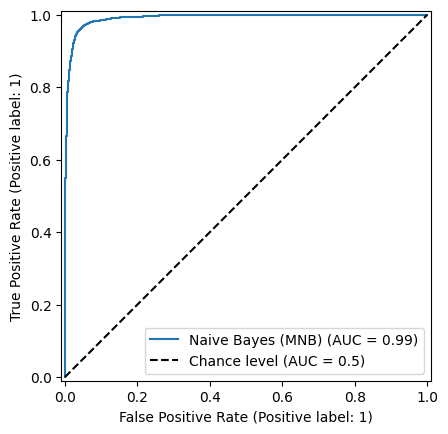

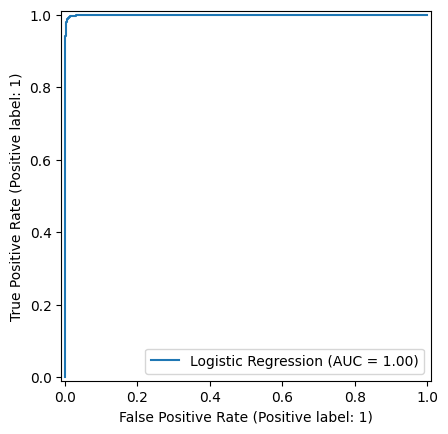

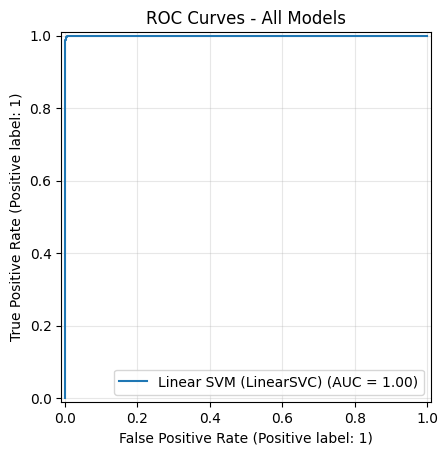

In [ ]:
# Plot ROC curves for all models
print("\nGenerating ROC curves...")
plt.figure(figsize=(10, 8))

for name, clf in models.items():
    y_scores = get_scores(clf, X_test)

    RocCurveDisplay.from_predictions(
        y_test,
        y_scores,
        name=name,
        plot_chance_level=(name == "Naive Bayes (MNB)")  # Only once
    )

plt.title("ROC Curves - All Models")
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right")
plt.show()

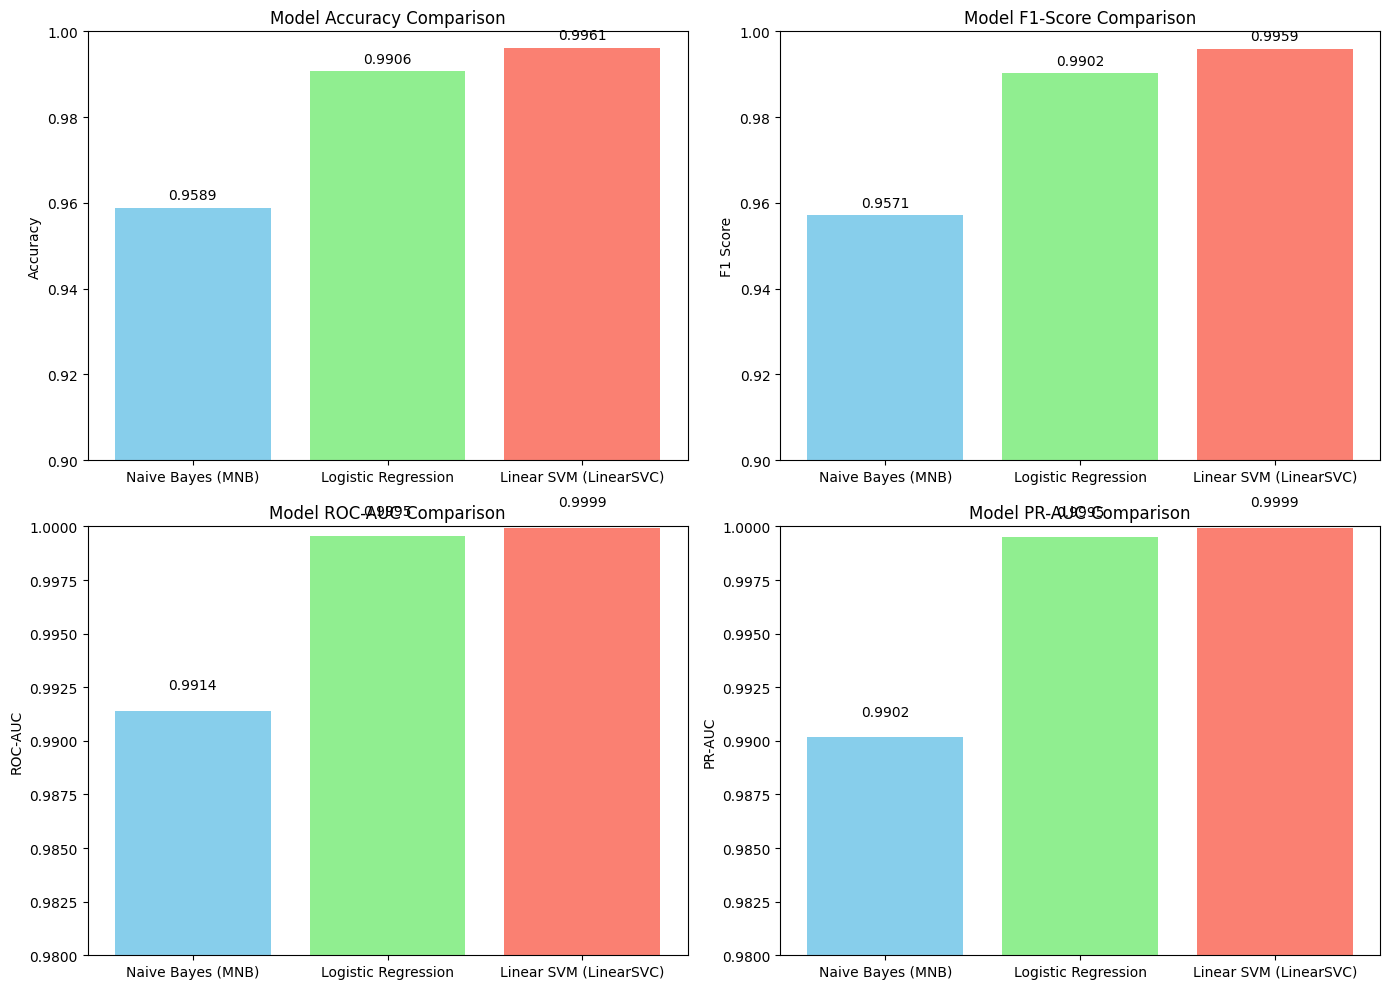


ANALYSIS COMPLETE!

Model Performance Ranking:
                 model  accuracy       f1  roc_auc   pr_auc
Linear SVM (LinearSVC)  0.996102 0.995920 0.999943 0.999938
   Logistic Regression  0.990646 0.990233 0.999548 0.999505
     Naive Bayes (MNB)  0.958909 0.957078 0.991404 0.990170


In [ ]:
# Create a summary comparison plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Accuracy Comparison
models_names = [r["model"] for r in results]
accuracies = [r["accuracy"] for r in results]
axes[0, 0].bar(models_names, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
axes[0, 0].set_title("Model Accuracy Comparison")
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].set_ylim(0.9, 1.0)
for i, v in enumerate(accuracies):
    axes[0, 0].text(i, v + 0.002, f"{v:.4f}", ha='center')

# 2. F1-Score Comparison
f1_scores = [r["f1"] for r in results]
axes[0, 1].bar(models_names, f1_scores, color=['skyblue', 'lightgreen', 'salmon'])
axes[0, 1].set_title("Model F1-Score Comparison")
axes[0, 1].set_ylabel("F1 Score")
axes[0, 1].set_ylim(0.9, 1.0)
for i, v in enumerate(f1_scores):
    axes[0, 1].text(i, v + 0.002, f"{v:.4f}", ha='center')

# 3. ROC-AUC Comparison
roc_scores = [r["roc_auc"] for r in results]
axes[1, 0].bar(models_names, roc_scores, color=['skyblue', 'lightgreen', 'salmon'])
axes[1, 0].set_title("Model ROC-AUC Comparison")
axes[1, 0].set_ylabel("ROC-AUC")
axes[1, 0].set_ylim(0.98, 1.0)
for i, v in enumerate(roc_scores):
    axes[1, 0].text(i, v + 0.001, f"{v:.4f}", ha='center')

# 4. PR-AUC Comparison
pr_scores = [r["pr_auc"] for r in results]
axes[1, 1].bar(models_names, pr_scores, color=['skyblue', 'lightgreen', 'salmon'])
axes[1, 1].set_title("Model PR-AUC Comparison")
axes[1, 1].set_ylabel("PR-AUC")
axes[1, 1].set_ylim(0.98, 1.0)
for i, v in enumerate(pr_scores):
    axes[1, 1].text(i, v + 0.001, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)
print("\nModel Performance Ranking:")
results_df_sorted = results_df.sort_values("accuracy", ascending=False)
print(results_df_sorted.to_string(index=False))

In [ ]:
# Save the trained models and results
import joblib
import datetime

# Create timestamp for file names
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Save models
for name, clf in models.items():
    filename = f"model_{name.replace(' ', '_').replace('(', '').replace(')', '')}_{timestamp}.pkl"
    joblib.dump(clf, filename)
    print(f"✓ Saved model: {filename}")

# Save results
results_df.to_csv(f"model_results_{timestamp}.csv", index=False)
print(f"✓ Saved results: model_results_{timestamp}.csv")

# Save TF-IDF vectorizer
joblib.dump(tfidf, f"tfidf_vectorizer_{timestamp}.pkl")
print(f"✓ Saved TF-IDF vectorizer")

print("\nAll files saved successfully!")

✓ Saved model: model_Naive_Bayes_MNB_20260121_075236.pkl
✓ Saved model: model_Logistic_Regression_20260121_075236.pkl
✓ Saved model: model_Linear_SVM_LinearSVC_20260121_075236.pkl
✓ Saved results: model_results_20260121_075236.csv
✓ Saved TF-IDF vectorizer

All files saved successfully!
